In [1]:
from math import log
import treePlotter,csv 
import numpy as np
def createDataSet1():
    data=[
        [0, 0, 0, 0, 'yes'],
        [0, 1, 0, 1, 'yes'],
        [0, 2, 1, 0, 'no'],
        [0, 2, 1, 1, 'no'],
        [0, 1, 1, 0, 'no'],
        [1, 2, 1, 0, 'yes'],
        [1, 0, 0, 1, 'yes'],
        [1, 1, 1, 1, 'yes'],
        [1, 2, 0, 0, 'yes'],
        [2, 1, 1, 0, 'yes'],
        [2, 0, 0, 0, 'yes'],
        [2, 1, 0, 0, 'yes'],
        [2, 0, 0, 1, 'no'],
        [2, 1, 1, 1, 'no']
        ]
    features=['weather','temperature','humidity','wspeed']
    return data,features

data1,features1 = createDataSet1()
features1

['weather', 'temperature', 'humidity', 'wspeed']

In [2]:
def calcShannonEnt(dataSet):
    """
    函数：计算数据集香农熵
    参数：dataSet:数据集
        labels:数据标签
    返回：shannonEnt 数据集对应的香农熵
    """
    numEntries = len(dataSet) #样本数
    labelCounts = {} #统计不同label出现次数的字典（key为label,value为出现次数）
    shannonEnt = 0.0
    
    #计算labelCounts
    for featVec in dataSet:
        # 获取当前这条数据的label值
        currentLabel = featVec[-1]
        # 是新label，则在标签字典中新建对应的key，value的对应出现的次数，初始化为0
        # 已有则当前label出现次数+1
        labelCounts[currentLabel] = labelCounts.get(currentLabel,0) + 1
    
    ### START CODE HERE ###
    
    for key in labelCounts:
        shannonEnt -= ( labelCounts[key] / numEntries ) * np.log2( labelCounts[key] / numEntries )
    
    ### END CODE HERE ###   
    
    return shannonEnt

In [3]:
print(calcShannonEnt(data1))
data1[0][-1] = 'maybe' #尝试增加一个分类选项，观察熵变化
print(calcShannonEnt(data1)) 
data1[0][-1] = 'yes' #还原

0.9402859586706311
1.2638091738835462


In [4]:
def splitDataSet(dataSet, axis, value):
    """
    函数：将axis列属性值为value的组合为一个数据集，并删除第axis列特征信息
    参数：axis:特征列索引
        value:待分离的特征取值
    返回：retDataSet:被分割出来的数据集
    """
    retDataSet = []
    for data in dataSet:
        # 如果数据集的第axis列值等于value，保留条数据，并删除第axis列特征信息
        if data[axis] == value:
            # 获取被降维特征前面的所有特征
            reducedFeatVec = data[:axis]
            # 接上被降维特征后面的所有特征
            reducedFeatVec.extend(data[axis + 1:])
            # 新的降维数据加入新的返回数据集中
            retDataSet.append(reducedFeatVec)
    return retDataSet

splitDataSet(data1,0,1) 

[[2, 1, 0, 'yes'], [0, 0, 1, 'yes'], [1, 1, 1, 'yes'], [2, 0, 0, 'yes']]

In [5]:
def chooseBestFeature_ID3(dataSet):
    """
    函数：利用香农熵，计算所有可能划分的信息增益，输出当前数据集最好的分类特征
    参数：dataSet
    返回：bestFeature:最优特征的index(下标)
    """
    numFeatures = len(dataSet[0]) - 1 #特征数
    baseEntropy = calcShannonEnt(dataSet) #Ent(D)
    bestInfoGain = 0.0 #信息增益
    bestFeature = -1 #最好信息增益特征
    
    #遍历每个特征
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList) #第i个特征的可能取值
        newEntropy = 0.0
        
        ### START CODE HERE ###

        #计算以第i个特征划分产生的infoGain
        for value in uniqueVals:
            retDataSet = splitDataSet(dataSet, i, value)
            newEntropy += ( len(retDataSet) / len(dataSet) ) * calcShannonEnt(retDataSet)
        infoGain = calcShannonEnt(dataSet) - newEntropy
        
        #如果大于当前bestInfoGain，则保留当前划分为最优划分
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
        
        ### END CODE HERE ###   
    return bestFeature

chooseBestFeature_ID3(data1)

0

In [6]:
def majorityCnt(classList):
    """
    函数：计算占比最大的分类标签
    参数：classList分类标签
    返回：占比最大的分类标签
    """
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
    return max(classCount, key=classCount.get)

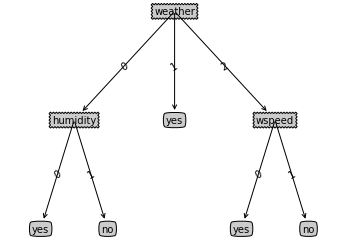

In [7]:
def createTree(dataSet, features, chooseBestFeature):
    """
    函数：递归地根据数据集和数据特征名创建决策树
    参数：chooseBestFeature:函数作为参数，通过chooseBestFeature(dataSet)调用，
        根据参数的不同，获取由ID3或C4.5算法选择的最优特征的index
    返回：myTree:由集合表示的决策树
    """
    classList = [data[-1] for data in dataSet] #当前数据集的所有标签
    bestFeat = chooseBestFeature(dataSet) #当前数据集最优特征
    bestFeatName = features[bestFeat]   #最优特征的标签名
    myTree = {bestFeatName: {}} #构造当前结点——最优特征:子结点集合
    bestFeatValues = set([data[bestFeat] for data in dataSet]) #最优特征可能的取值，set去重

    del(features[bestFeat]) #删除已用过的分类标签
    
    ### START CODE HERE ###
    
    # 如果当前dataSet所有的标签相同，此结点分类完毕，结束决策，返回分类标签
    # 如果当前dataSet无特征，此结点分类完毕，结束决策，返回占比最大的分类标签
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 0:
        return classList[0]
    if len(features) == 1:
        return classList[0]

    # 否则，为每个最优特征取值，递归地创建子树
    for value in bestFeatValues:
        subFeatures = features.copy()
        myTree[bestFeatName][value] = createTree(splitDataSet(dataSet, bestFeat, value), subFeatures, chooseBestFeature)
    
        
    ### END CODE HERE ###  

    return myTree

data1, labels1 = createDataSet1()
ID3Tree = createTree(data1, labels1,chooseBestFeature_ID3)
treePlotter.createPlot(ID3Tree)

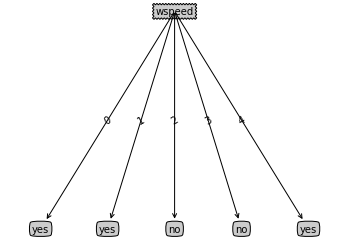

In [8]:
def createDataSet2():
    data=[
            [0, 0, 1, 0, 'yes'],
            [1, 1, 0, 1, 'yes'],
            [0, 0, 0, 2, 'no'],
            [0, 1, 1, 3, 'no'],
            [1, 1, 1, 4, 'yes']
            ]
    features2=['weather','temperature','humidity','wspeed']
    return data,features2
data2, features2 = createDataSet2()
ID3Tree = createTree(data2, features2, chooseBestFeature_ID3)
treePlotter.createPlot(ID3Tree)

In [9]:
def chooseBestFeature_C45(dataSet):
    """
    函数：计算所有可能划分的信息增益比，输出当前数据集最好的分类特征
    参数：dataSet
    返回：bestFeature:最优特征的index(下标)
    """
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList) 
        newEntropy = 0.0
        IV = 0.0 
        
        ### START CODE HERE ### 

        # 计算以第i个特征划分的infoGain，以及其IV
        # 注意IV=0时直接continue，可以思考一下什么情况会使IV=0
        for value in uniqueVals:
            retDataSet = splitDataSet(dataSet, i, value)
            newEntropy += ( len(retDataSet) / len(dataSet) ) * calcShannonEnt(retDataSet)
            IV -= ( len(retDataSet) / len(dataSet) ) * np.log2( len(retDataSet) / len(dataSet))
        infoGain = calcShannonEnt(dataSet) - newEntropy 
        if IV == 0:
            continue
        
        # 计算GainRatio衰减
        # 如果大于当前最优，则保留当前划分为最优划分
        GainRatio = infoGain / IV
        if GainRatio > bestInfoGain:
            bestInfoGain = GainRatio
            bestFeature = i
        
        
        ### END CODE HERE ###
    
    return bestFeature

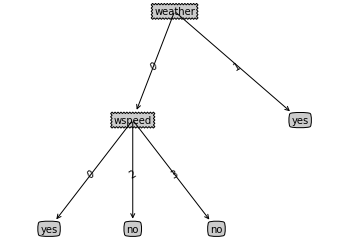

In [10]:
data2, labels2 = createDataSet2()
C45Tree = createTree(data2, labels2, chooseBestFeature_C45)
treePlotter.createPlot(C45Tree)

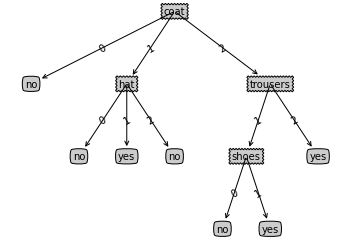

In [11]:
def createDataSet3():
    data=[
            [1, 2, 1, 0, 2, 0, 'yes'],
            [2, 2, 2, 0, 2, 0, 'yes'],
            [2, 2, 1, 0, 2, 0, 'yes'],
            [1, 1, 1, 0, 1, 1, 'yes'],
            [2, 1, 1, 1, 1, 1, 'yes'],
            [1, 0, 0, 0, 0, 1, 'no'],
            [0, 1, 2, 1, 2, 0, 'no'],
            [2, 1, 1, 0, 1, 1, 'no'],
            [0, 2, 1, 2, 0, 0, 'no'],
            [1, 2, 2, 1, 1, 0, 'no']
            ]
    testdata=[
            [1, 2, 2, 0, 2, 0, 'yes'],
            [0, 2, 1, 0, 2, 0, 'yes'],
            [2, 1, 1, 0, 1, 0, 'yes'],
            [2, 0, 2, 1, 1, 0, 'no'],
            [0, 0, 0, 2, 0, 0, 'no'],
            [0, 2, 1, 2, 0, 1, 'no'],
            [1, 1, 1, 1, 2, 0, 'no']
            ]
    features3=['coat','trousers','hat','shoes','shirt','scarf']
    return data,testdata,features3
data3, testdata, features3 = createDataSet3()
ID3Tree = createTree(data3, features3, chooseBestFeature_ID3)
treePlotter.createPlot(ID3Tree)

In [12]:
def testingMajor(major, data_test):
    """
    函数：计算不保留子树造成的错误数量
    参数：data_test，major：占比最大的分类标签
    返回：错误数量
    """
    error = 0.0
    for i in range(len(data_test)):
        if major != data_test[i][-1]:
            error += 1

    return float(error)

In [13]:
def testing_feat(bestFeatIndex, train_data, test_data, labels):
    """
    函数：计算保留子树造成的错误数量
    参数：bestFeatIndex:最优特征的index(下标)，train_data：训练数据集, test_data：测试数据集, labels：数据标签
    返回：错误数量
    """
    class_list = [example[-1] for example in train_data]
    train_data = [example[bestFeatIndex] for example in train_data]
    test_data = [(example[bestFeatIndex], example[-1]) for example in test_data]
    all_feat = set(train_data)
    error = 0.0
    for value in all_feat:
        class_feat = [class_list[i] for i in range(len(class_list)) if train_data[i] == value]
        major = majorityCnt(class_feat)
        for data in test_data:
            if data[0] == value and data[1] != major:
                error += 1.0
    return error

In [16]:
def createTree_prune(dataSet,labels,test_data,chooseBestFeature,mode='prev'):
    """
    函数：递归地根据数据集和数据特征名创建预剪枝决策树
    参数：dataSet：训练数据集，labels：数据标签，test_data：测试数据集，chooseBestFeature:函数作为参数，通过chooseBestFeature(dataSet)调用，
        根据参数的不同，获取由ID3或C4.5算法选择的最优特征的index
    返回：myTree:由集合表示的决策树
    """
    classList=[example[-1] for example in dataSet]
    # dataSet指的是当前的数据集,不是最初的数据集
    # classList指的是当前数据集的所有标签(不去重)

    #下面是递归截止条件
    if classList.count(classList[0])==len(classList):#这个意思是如果当前数据集中的所有数据都属于同一个类别
        return classList[0]
    if len(dataSet[0])==1:
        return majorityCnt(classList)

    #选择最佳分割特征
    labels_copy = labels
    #labels_copy = copy.deepcopy(labels)#深拷贝就是:labels_copy和lables撇清关系
    bestFeat=chooseBestFeature(dataSet)
    bestFeatLabel=labels[bestFeat]

    if mode == "prev":
        
        ### START CODE HERE ###
        
        #如果剪枝前的错误数量小于剪枝后的错误数量,那么就保留该子树
        if testing_feat(bestFeat,dataSet,test_data,labels_copy) < testingMajor(majorityCnt(classList),dataSet):
            myTree = {bestFeatLabel: {}}
        else:
            return majorityCnt(classList) 
        
        ### END CODE HERE ###

    myTree = {bestFeatLabel: {}}
    featValues=[example[bestFeat] for example in dataSet]
    uniqueVals=set(featValues)
    #uniqueVals用来获得当前数据集的最佳分割属性剩余的取值有哪些

    del (labels[bestFeat])#删除根节点的已经用过的特征

    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree_prune(splitDataSet(dataSet, bestFeat, value), subLabels,splitDataSet(test_data, bestFeat, value),chooseBestFeature, mode=mode)

    return myTree

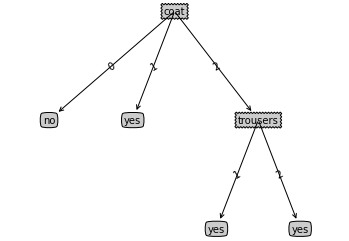

In [17]:
data3, testdata, features3 = createDataSet3()
MyTree = createTree_prune(data3, features3, testdata, chooseBestFeature_ID3)
treePlotter.createPlot(MyTree)

In [18]:
def createDataSetIris():
    '''
    函数：获取鸢尾花数据集，以及预处理
    返回：
        Data:构建决策树的数据集(因打乱有一定随机性)
        Data_test:手动划分的测试集
        featrues：特征名列表
        labels：标签名列表
    '''
    labels = ["setosa","versicolor","virginica"]
    with open('iris.csv','r') as f:
        rawData = np.array(list(csv.reader(f)))
        features = np.array(rawData[0,1:-1]) 
        dataSet = np.array(rawData[1:,1:]) #去除序号和特征列
        np.random.shuffle(dataSet) #打乱（之前如果不加array()得到的会是引用，rawData会被一并打乱）
    return rawData[1:,1:], dataSet, features, labels

rawData, data, features, labels = createDataSetIris()
print(rawData[0]) 
print(data[0])
print(features) 
print(labels) 

['5.1' '3.5' '1.4' '0.2' 'setosa']
['6.7' '3.1' '4.7' '1.5' 'versicolor']
['Sepal.Length' 'Sepal.Width' 'Petal.Length' 'Petal.Width']
['setosa', 'versicolor', 'virginica']


In [19]:
def calcGiniIndex(dataSet):
    '''
    函数：计算数据集基尼值
    参数：dataSet:数据集
    返回: Gini值
    ''' 
    counts = [] #每个标签在数据集中出现的次数
    count = len(dataSet) #数据集长度
    for label in labels:
        counts.append([d[-1] == label for d in dataSet].count(True))
    
    ### START CODE HERE ###    
    temp = 0
    for i in counts:
        temp += (i / count) ** 2
    gini = 1 - temp
    
    
    ### END CODE HERE ###
    
    return gini

calcGiniIndex(rawData) 

0.6666666666666667

In [20]:
def binarySplitDataSet(dataSet, feature, value):
    '''
    函数：将数据集按特征列的某一取值换分为左右两个子数据集
    参数：dataSet:数据集
        feature:数据集中某一特征列
        value:该特征列中的某个取值
    返回：左右子数据集
    '''
    matLeft = np.array([d for d in dataSet if d[feature] <= value])
    matRight = np.array([d for d in dataSet if d[feature] > value])
    return matLeft,matRight

binarySplitDataSet(rawData,0,"4.7")[0]

array([['4.7', '3.2', '1.3', '0.2', 'setosa'],
       ['4.6', '3.1', '1.5', '0.2', 'setosa'],
       ['4.6', '3.4', '1.4', '0.3', 'setosa'],
       ['4.4', '2.9', '1.4', '0.2', 'setosa'],
       ['4.3', '3', '1.1', '0.1', 'setosa'],
       ['4.6', '3.6', '1', '0.2', 'setosa'],
       ['4.7', '3.2', '1.6', '0.2', 'setosa'],
       ['4.4', '3', '1.3', '0.2', 'setosa'],
       ['4.5', '2.3', '1.3', '0.3', 'setosa'],
       ['4.4', '3.2', '1.3', '0.2', 'setosa'],
       ['4.6', '3.2', '1.4', '0.2', 'setosa']], dtype='<U12')

In [21]:
def classifyLeaf(dataSet, labels):
    '''
    函数：求数据集最多的标签，用于结点分类
    参数：dataSet:数据集
        labels:标签名列表
    返回：该标签的index
    '''
    counts = [] 
    for label in labels:
        counts.append([d[-1] == label for d in dataSet].count(True))
    return np.argmax(counts) #argmax：使counts取最大值的下标

classifyLeaf(rawData[40:120],labels) 

1

In [22]:
def chooseBestSplit(dataSet, labels, leafType=classifyLeaf, errType=calcGiniIndex, threshold=(0.01,7)):
    '''
    函数：利用基尼系数选择最佳划分特征及相应的划分点
    参数：dataSet:数据集
        leafType:叶结点输出函数(当前实验为分类)
        errType:损失函数，选择划分的依据(分类问题用的就是GiniIndex)
        threshold: Gini阈值，样本阈值(结点Gini或样本数低于阈值时停止)
    返回：bestFeatureIndex:划分特征
        bestFeatureValue:最优特征划分点
    '''
    thresholdErr = threshold[0] #Gini阈值
    thresholdSamples = threshold[1] #样本阈值
    err = errType(dataSet)
    bestErr = np.inf
    bestFeatureIndex = 0 #最优特征的index
    bestFeatureValue = 0 #最优特征划分点

    ### START CODE HERE ###    
    
    #当数据中输出值都相等时，返回叶结点（即feature=None,value=结点分类）
    if err == 0:
        return None,dataSet[0][-1]

    #尝试所有特征的所有取值，二分数据集，计算err(本实验为Gini)，保留bestErr
    for i in range(len(dataSet[0]) - 1):
        uniqueVals = set([example[i] for example in dataSet])
        for value in uniqueVals:
            leftSet,rightSet = binarySplitDataSet(dataSet, i, value)
            if len(leftSet) < thresholdSamples or len(rightSet) < thresholdSamples:
                continue
            gini = (len(leftSet) * calcGiniIndex(leftSet) + len(rightSet) * calcGiniIndex(rightSet)) / (len(leftSet) + len(rightSet))
            if gini < bestErr:
                bestErr = gini
                bestFeatureIndex = i
                bestFeatureValue = value
    
    #检验Gini阈值，若是则不再划分，返回叶结点
    if (err - bestErr)<thresholdErr:
        return None,labels[leafType(dataSet, labels)]
    
    #检验左右数据集的样本数是否小于阈值，若是则不再划分，返回叶结点

    
    
    ### END CODE HERE ###  
    
    return bestFeatureIndex,bestFeatureValue

chooseBestSplit(rawData, labels)

(2, '1.9')

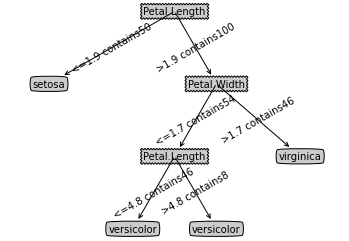

In [23]:
def createTree_CART(dataSet, labels, leafType=classifyLeaf, errType=calcGiniIndex, threshold=(0.01,7)):

    '''
    函数：建立CART树
    参数：dataSet:数据集
        leafType:叶结点输出函数(当前实验为分类)
        errType:损失函数，选择划分的依据(分类问题用的就是GiniIndex)
        threshold: Gini阈值，样本阈值(结点Gini或样本数低于阈值时停止)
    返回：CART树
    '''
    feature,value = chooseBestSplit(dataSet, labels, leafType, errType, threshold)

    ### START CODE HERE ###    

    #是叶结点则返回决策分类（chooseBestSplit返回None时表明这里是叶结点）
    #否则创建分支，递归生成子树
    if feature is None:
        return value
    leftSet,rightSet = binarySplitDataSet(dataSet, feature, value)   
    myTree = {}
    myTree[features[feature]] = {}
    myTree[features[feature]]['<=' + str(value) + ' contains' + str(len(leftSet))] = createTree_CART(leftSet, np.array(leftSet)[:,-1], leafType, errType,threshold)
    myTree[features[feature]]['>' + str(value) + ' contains' + str(len(rightSet))] = createTree_CART(rightSet, np.array(rightSet)[:,-1], leafType, errType,threshold)

    
    ### END CODE HERE ###    
    
    return myTree

CARTTree = createTree_CART(data, labels, classifyLeaf, calcGiniIndex, (0.01,7))
treePlotter.createPlot(CARTTree)